In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,mean_absolute_error
from sklearn.utils.class_weight import compute_class_weight




In [2]:

# Load the Data
df = pd.read_csv("final_pre-processed.csv")
df = df.drop('Unnamed: 0',axis=1)
df["Ratings"] = df["Ratings"].astype(int)


In [3]:
df["Ratings"].value_counts()

1    4534
0     634
Name: Ratings, dtype: int64

In [4]:
test_Ratings = df["Ratings"]
rate = []
for i in test_Ratings:
    if int(i) >=4:
        rate.append(1)
    else:
        rate.append(0)
df["Ratings"] = rate

In [4]:
pd.DataFrame(rate).value_counts()

NameError: name 'rate' is not defined

In [5]:
# PARAMETERS
NUM_ROUNDS = 1
NUM_CLIENTS = 1
BATCH_SIZE = 10
EPOCHS_PER_ROUND = 1
LEARNING_RATE = 0.1
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-7

In [6]:
df["Ratings"] = rate

NameError: name 'rate' is not defined

In [7]:
df

,reviewText,Ratings
0,Microsoft Office is still the standard all the...,1
1,Been using Office for over twenty years. Stil...,0
2,Always liked Office Products. Expensive for a...,1
3,I have been using MS Office professional for d...,1
4,This is really a great buy. It breaks down to...,1
...,...,...
5163,Arrived as described. I was pleased with purc...,1
5164,Was not what I expected,0
5165,great buy,1
5166,"The product itself is quite good, in depth fix...",1


In [8]:
from wordcloud import WordCloud

# Separate positive and negative reviews
positive_reviews = df[df['Ratings'] == 1]['reviewText'].values
negative_reviews = df[df['Ratings'] == 0]['reviewText'].values

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


ModuleNotFoundError: No module named 'wordcloud'

In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cpu")


class LocalDataLoader():

    def __init__(self,df,batch_size):
        self.train_text, self.temp_text, self.train_labels, self.temp_labels = train_test_split(df['reviewText'], df['Ratings'],random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Ratings'])
        self.val_text, self.test_text, self.val_labels, self.test_labels = train_test_split(self.temp_text, self.temp_labels, random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=self.temp_labels)
        
        # Load the BERT tokenizer
        self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        self.batch_size = batch_size




    def tokenize(self):
        # tokenize and encode sequences in the training set
        self.tokens_train = self.tokenizer.batch_encode_plus(
            self.train_text.tolist(),
            max_length=25,
            pad_to_max_length=True,
            truncation=True
        )
        # tokenize and encode sequences in the validation set
        self.tokens_val = self.tokenizer.batch_encode_plus(
            self.val_text.tolist(),
            max_length = 25,
            pad_to_max_length=True,
            truncation=True
        )
        # tokenize and encode sequences in the test set
        self.tokens_test = self.tokenizer.batch_encode_plus(self.test_text.tolist(),max_length = 25,pad_to_max_length=True,
                                                  truncation=True)
        
        
    

    def masking(self):
        self.tokenize()

        train_seq = torch.tensor(self.tokens_train['input_ids'])
        train_mask = torch.tensor(self.tokens_train['attention_mask'])
        train_y = torch.tensor(self.train_labels.tolist())

        val_seq = torch.tensor(self.tokens_val['input_ids'])
        val_mask = torch.tensor(self.tokens_val['attention_mask'])
        val_y = torch.tensor(self.val_labels.tolist())
        
        test_seq = torch.tensor(self.tokens_test['input_ids'])
        test_mask = torch.tensor(self.tokens_test['attention_mask'])
        test_y = torch.tensor(self.test_labels.tolist())


        train_data = TensorDataset(train_seq, train_mask, train_y)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)

        val_data = TensorDataset(val_seq, val_mask, val_y)
        val_sampler = SequentialSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=self.batch_size)

        return train_dataloader,val_dataloader,test_mask,test_seq,test_y
    

    




ModuleNotFoundError: No module named 'transformers'

In [29]:

# function to train the model
def train(train_dataloader,model,cross_entropy,optimizer):
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        # push the batch to gpu
        batch = [r.to('cpu') for r in batch]
        sent_id, mask, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds


In [30]:

# function for evaluating the model
def evaluate(val_dataloader,model,cross_entropy):
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to('cpu') for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

     


In [31]:

test_mask = None
test_seq = None
test_y = None

def Federated_rounds(rounds):
    client_weights = []
    client_losses = []
    client_acc = []
    client_mae = []
    client_train_losses = []
    for i in range(0,NUM_CLIENTS):
        decentral_data = df_clients[i]
        loader = LocalDataLoader(decentral_data,BATCH_SIZE)
        train_loader,val_loader,test_mask,test_seq,test_y = loader.masking()

        for param in bert.parameters():
            param.requires_grad = False

        # pass the pre-trained BERT to our define architecture
        model = BERT_Arch(bert)
        model = model.to('cpu')

        optimizer = AdamW(model.parameters(),lr = 1e-5) 

        class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(loader.train_labels), y= loader.train_labels)
        weights= torch.tensor(class_weights,dtype=torch.float)
        weights = weights.to('cpu')

        # define the loss function
        cross_entropy  = nn.NLLLoss(weight=weights) 
        # set initial loss to infinite
        best_valid_loss = float('inf')

        # empty lists to store training and validation loss of each epoch
        train_losses=[]
        valid_losses=[]
        for epoch in range(EPOCHS_PER_ROUND):
            print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS_PER_ROUND))
            #train model
            train_loss, _ = train(train_loader,model,cross_entropy,optimizer)
            #evaluate model
            valid_loss, _ = evaluate(val_loader,model,cross_entropy)
            #save the best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), 'weights/saved_weights'+str(i+1)+'.pt')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            print(f'\nTraining Loss: {train_loss:.3f}')
            print(f'Validation Loss: {valid_loss:.3f}')
        with torch.no_grad():
            preds = model(test_seq.to('cpu'), test_mask.to('cpu'))
            preds = preds.detach().cpu().numpy()
        # model's performance
        preds = np.argmax(preds, axis = 1)
        client_train_losses.append(train_losses)
        client_losses.append(valid_losses)
        client_weights.append(model.state_dict())
        client_acc.append(accuracy_score(test_y, preds))
        client_mae.append(mean_absolute_error(test_y,preds))
        data = [client_acc, client_train_losses, client_losses, client_mae]
        data = list(map(list, zip(*data)))
        column_names = ['Accuracy', 'Train Losses', 'Test Losses', 'MAE']
        df = pd.DataFrame(data, columns=column_names)
        df.to_csv('results.csv')
        num_clients = list(range(1, NUM_CLIENTS + 1))
        epochs = range(1, len(client_losses) + 1)
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
        
        # Plot client accuracy at that round
        ax1.plot(num_clients, client_acc, marker='o', linestyle='-', color='b')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Clients Accuracy')
        ax1.grid(True)

        # Plot loss values
        ax2.plot(epochs, client_losses, marker='o', linestyle='-', color='b', label='Loss')
        ax2.set_ylabel('Loss')
        ax2.set_title('Loss vs Accuracy')
        ax2.grid(True)

        # Plot accuracy values
        ax3.plot(epochs, client_acc, marker='o', linestyle='-', color='r', label='Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.grid(True)

        # Add legends
        ax2.legend()
        ax3.legend()

        # Save the combined plot
        plt.savefig("combined_plot"+str(rounds)+".png")        
        
        return client_weights;





In [32]:
def g_evaluate(model):
    loader = LocalDataLoader(test_new,20)
    train_loader,val_loader,test_mask,test_seq,test_y = loader.masking()
    # get predictions for test data
    with torch.no_grad():
        preds = model(test_seq.to('cpu'), test_mask.to('cpu'))
        preds = preds.detach().cpu().numpy()

    # model's performance
    preds = np.argmax(preds, axis = 1)
    print(classification_report(test_y, preds))
    print(mean_absolute_error(test_y,preds))
    return accuracy_score(test_y,preds),mean_absolute_error(test_y,preds);






In [33]:
# Initialize the global model
global_model = BERT_Arch(bert)
global_model = global_model.to('cpu')
g_acc = []
g_mae = []

for i in range(NUM_ROUNDS):
    # Initialize the optimizer for the global model with AdamW
    optimizer = AdamW(global_model.parameters(), lr=1e-5)
    # Initialize a list to store the local model parameters
    local_parameters = global_model.parameters()
    
    client_weights = Federated_rounds(i)

    # Perform federated averaging
    for j in range(NUM_CLIENTS):
        # Load the weights from the second model file into model2
        path2 = client_weights[j]
        model2 = BERT_Arch(bert)
        model2.load_state_dict(client_weights[j])  # Load the model state_dict from file

        # Update local parameters with the parameters from model2
        for param1, param2 in zip(local_parameters, model2.parameters()):
            param1.data += param2.data

    # Average the parameters across all clients
    for params in local_parameters:
        for param in params:
            param.data /= NUM_CLIENTS  # Use param.data to modify the tensor in-place

    # Update the global model with the averaged parameters
    for param1, avg_params in zip(global_model.parameters(), local_parameters):
        param1.data = avg_params.data

    acc, mae = g_evaluate(global_model)
    g_acc.append(acc)
    g_mae.append(mae)

NameError: name 'BERT_Arch' is not defined

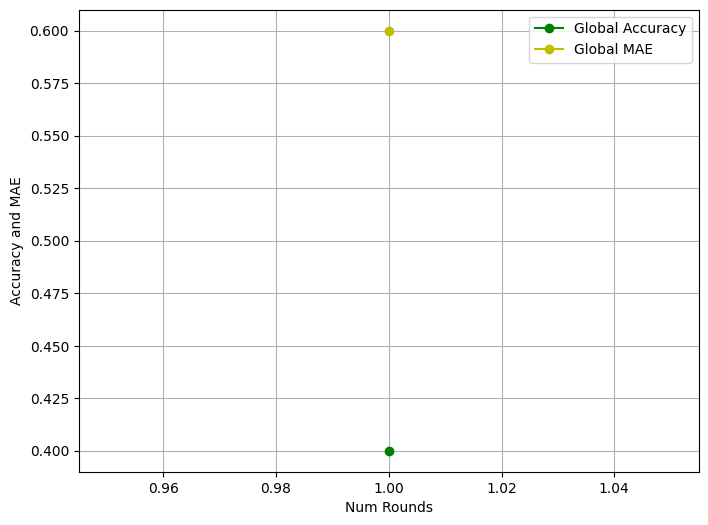

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot global accuracy and MAE
ax.plot(NUM_ROUNDS, g_acc, marker='o', linestyle='-', color='g', label='Global Accuracy')
ax.plot(NUM_ROUNDS, g_mae, marker='o', linestyle='-', color='y', label='Global MAE')
ax.set_xlabel('Num Rounds')
ax.set_ylabel('Accuracy and MAE')
ax.grid(True)

# Add legend
ax.legend()

# Save the combined plot
plt.savefig("global_metrics.png")

# Show the plot (if needed)
plt.show()